In [1]:
import psycopg2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
sns.set(style="white")

In [2]:
## connect to database

con = psycopg2.connect("dbname='doctordb' user='cathy'")

In [3]:
q = "SELECT * FROM payments WHERE provider_type = 'Medical Oncology'"
payments = pd.read_sql_query(q, con=con)

In [4]:
payments.shape

(53502, 26)

In [6]:
payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53502 entries, 0 to 53501
Data columns (total 26 columns):
npi                                 53502 non-null object
nppes_provider_last_org_name        53502 non-null object
nppes_provider_first_name           53502 non-null object
nppes_provider_mi                   40248 non-null object
nppes_credentials                   53040 non-null object
nppes_provider_gender               53502 non-null object
nppes_entity_code                   53502 non-null object
nppes_provider_street1              53502 non-null object
nppes_provider_street2              26598 non-null object
nppes_provider_city                 53502 non-null object
nppes_provider_zip                  53502 non-null object
nppes_provider_state                53502 non-null object
nppes_provider_country              53502 non-null object
provider_type                       53502 non-null object
medicare_participation_indicator    53502 non-null object
place_of_service     

In [96]:
payments.drop_duplicates(['npi']).head()

,npi,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_mi,nppes_credentials,nppes_provider_gender,nppes_entity_code,nppes_provider_street1,nppes_provider_street2,nppes_provider_city,...,hcpcs_code,hcpcs_description,hcpcs_drug_indicator,line_srvc_cnt,bene_unique_cnt,bene_day_srvc_cnt,average_medicare_allowed_amt,average_submitted_chrg_amt,average_medicare_payment_amt,average_medicare_standard_amt
0,1003019571,SEHGAL,RAJESH,None,MD,M,I,400 OXFORD DR,SUITE 102,MONROEVILLE,...,36415,Insertion of needle into vein for collection o...,N,101.0,52.0,101.0,3.00,20.00,2.94,2.94
20,1003087768,BATUS,MARTA,None,MD,F,I,1725 W HARRISON ST,SUITE 809,CHICAGO,...,99204,"New patient office or other outpatient visit, ...",N,15.0,15.0,15.0,143.37,289.00,112.40,103.36
28,1003166042,FINE,HOWARD,A,M.D.,M,I,160 E 34TH ST,None,NEW YORK,...,99212,Established patient office or other outpatient...,N,15.0,13.0,15.0,28.28,150.00,22.17,20.08
31,1003805409,WILLIAMS,STEPHANIE,F,MD,F,I,145 MICHIGAN ST NE,SUITE 5200,GRAND RAPIDS,...,99214,Established patient office or other outpatient...,N,39.0,16.0,39.0,77.51,146.49,57.42,63.08
34,1003807645,LUNIN,SCOTT,D,M.D.,M,I,3085 BOBCAT VILLAGE CENTER RD,None,NORTH PORT,...,36415,Insertion of needle into vein for collection o...,N,1746.0,645.0,1746.0,3.00,9.00,2.94,2.94


In [11]:
payments.groupby(['hcpcs_drug_indicator'])['npi'].count()

hcpcs_drug_indicator
N    40477
Y    13025
Name: npi, dtype: int64

In [94]:
# what kind of medicare part B drugs are there?
payments.loc[payments['hcpcs_drug_indicator'] == 'Y', ['hcpcs_code','hcpcs_description']].head()

,hcpcs_code,hcpcs_description
17,J1100,"Injection, dexamethasone sodium phosphate, 1mg"
18,J1200,"Injection, diphenhydramine hcl, up to 50 mg"
19,J1626,"Injection, granisetron hydrochloride, 100 mcg"
95,J0641,"Injection, levoleucovorin calcium, 0.5 mg"
96,J0885,"Injection, epoetin alfa, (for non-esrd use), 1..."


How many distinct hcpcs codes are there in the dataset?

In [26]:
payments.groupby(['hcpcs_drug_indicator','hcpcs_code']).count().shape

(635, 24)

In [72]:
counts_per_code = payments.groupby(['hcpcs_code']).count()['npi'].sort_values(ascending=False).reset_index()
counts_per_code.rename(columns={'npi':'counts'}, inplace=True)
counts_per_code.head()

,hcpcs_code,counts
0,99214,2761
1,99213,2108
2,99215,1892
3,99205,1856
4,99232,1478


In [83]:
pd.set_option('max_colwidth', 80)
(pd.merge(counts_per_code, payments[['hcpcs_code', 'hcpcs_description','hcpcs_drug_indicator']], sort=False)
    .drop_duplicates()
    .head(30))

,hcpcs_code,counts,hcpcs_description,hcpcs_drug_indicator
0,99214,2761,"Established patient office or other outpatient, visit typically 25 minutes",N
2761,99213,2108,"Established patient office or other outpatient visit, typically 15 minutes",N
4869,99215,1892,"Established patient office or other outpatient, visit typically 40 minutes",N
6761,99205,1856,"New patient office or other outpatient visit, typically 60 minutes",N
8617,99232,1478,"Subsequent hospital inpatient care, typically 25 minutes per day",N
10095,99233,1314,"Subsequent hospital inpatient care, typically 35 minutes per day",N
11409,99223,1201,"Initial hospital inpatient care, typically 70 minutes per day",N
12610,99204,1040,"New patient office or other outpatient visit, typically 45 minutes",N
13650,96372,987,"Injection beneath the skin or into muscle for therapy, diagnosis, or prevention",N
14637,96413,982,Infusion of chemotherapy into a vein up to 1 hour,N


What is the distribution of counts per code?

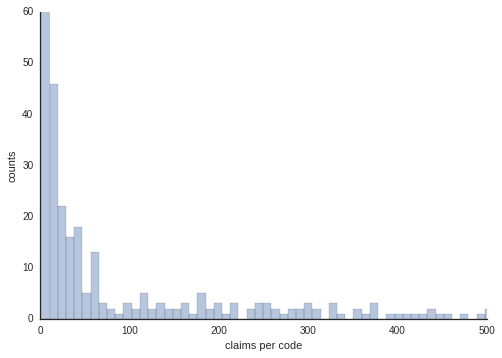

In [87]:
g = sns.distplot(counts_per_code['counts'], kde=False, bins=300)
g.set(xlim=(0,500), ylim=(0, 60), xlabel='claims per code', ylabel='counts')
sns.despine()

How many distinct hcpcs codes are associated with Medicare part B drugs?

In [25]:
payments.query("hcpcs_drug_indicator=='Y'").groupby(['hcpcs_drug_indicator','hcpcs_code']).count().shape

(143, 24)

## plot physicians based on features (counts per hcpcs_code)